In [1]:
import numpy as np


In [8]:

data=[[119,36],[45,55],[32,16]]
a=np.array(data)
np.sum(a,axis=0)
np.zeros(a.shape)


array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [63]:
#### Pearson Chi square
# Expected frequency = (Row total * Column total) / Grand total
# Calculate the chi-square statistic using the formula:
# χ² = Σ [(O - E)² / E]
# Where O is the observed frequency and E is the expected frequency for each cell.
# Determine the degrees of freedom (df). For a contingency table, df = (rows - 1) * (columns - 1).

import numpy as np
from scipy.stats import chi2

def chi_square(data,print_out=True):
    a=np.array(data) # a stores the observed values
    col_sum=np.sum(a,axis=0)
    row_sum=np.sum(a,axis=1)
    ttl_sum=np.sum(col_sum)
    
    chi_sq=0
    for y in range(a.shape[0]):
        for x in range(a.shape[1]):
            expected =row_sum[y]*col_sum[x]/ttl_sum
            chi_sq+=(a[y][x]-expected)**2/expected
    
    df=(a.shape[0]-1)*(a.shape[1]-1)
    
    p=1-chi2.cdf(chi_sq,df)
    
    if print_out:
        print("Chi_sq = %.2f"%chi_sq)
        print("df = %d"%df)
        print("Pearson P = %.2f"%p)
        
    return {"p":p,"chi_sq":chi_sq,"df":df}

In [64]:
data=[[17,63,58],[25,61,79]]
chi_square(data)

Chi_sq = 2.39
df = 2
Pearson P = 0.30


{'p': 0.3029966133373402, 'chi_sq': 2.3880673012794396, 'df': 2}

In [65]:
from scipy.stats import chisquare
chisquare(data)

Power_divergenceResult(statistic=array([1.52380952, 0.03225806, 3.2189781 ]), pvalue=array([0.21704391, 0.85746244, 0.07278906]))

In [66]:
import statistics as stat
import numpy as np
from scipy.stats import chi2, norm, kurtosis
from scipy.stats import f as f_dist
from math import log as ln

def chi2_test_stdev(data_list,s0,print_out=True):
    df=len(data_list)-1
    S=stat.variance(data_list)*df
    stdev=stat.stdev(data_list)
    chi_sq=S/s0/s0
    p=1-chi2.cdf(chi_sq,df)
    
    chi2_low0025=chi2.ppf(0.025,df)
    chi2_high0975=chi2.ppf(0.975,df)
    chi2_low005=chi2.ppf(0.05,df)
    stdev_range_low=(chi2_low0025*s0*s0/df)**.5
    stdev_range_high=(chi2_high0975*s0*s0/df)**.5
    
    std_range_from_S=((S/chi2_high0975)**.5,(S/chi2_low0025)**.5)
    
    std_from_S_high95=(S/chi2_low005)**.5
    
    if print_out:
        print("Population stdev: %.2f\nSampled stdev: %.2f"%(s0,stdev))
        print("df = %d"%df)
        print("chi square = %.2f"%chi_sq)
        print("Prob of variation is bigger than the sample. p = %.2f"%p)
        print("Lower %%2.5 Chi square = %.2f  Top %%2.5 Chi square = %.2f"%(
                chi2_low0025,chi2_high0975))
        print("%%95 confidence range of stdev: (%.2f, %.2f), when sampling %d times from a population with stdev of %.2f."%(
                stdev_range_low,stdev_range_high,df+1,s0))
        print("%%95 confidence range of the population stdev: (%.2f, %.2f), where the samples came from."%
             std_range_from_S)
        print("%%95 confidence the population stdev lower than %.2f, where the samples came from."
             %std_from_S_high95)
    
    return {"p":p,"chi_sq":chi_sq,"stdev":stdev,"df":df,"95_chi2_range":(chi2_low0025,
           chi2_high0975),"95_range_from_P":(stdev_range_low,stdev_range_high),"n":df+1,
           "95_range_from_S":std_range_from_S, "std_from_S_high95":std_from_S_high95}


def several_tests_stdev_2sided(l1,l2,print_out=True):
    var1=stat.variance(l1)
    var2=stat.variance(l2)
    u1=stat.mean(l1)
    u2=stat.mean(l2)
    s1=stat.stdev(l1)
    s2=stat.stdev(l2)
    n1=len(l1)
    n2=len(l2)
    k1=kurtosis(l1,fisher=True,bias=False) # This replicates Minitab result
    k2=kurtosis(l2,fisher=True,bias=False)
    res={"u1":u1,"u2":u2,"s1":s1,"s2":s2,"n1":n1,"n2":n2,"k1":k1,"k2":k2}
#     print(k1,k2)
    
    f=var1/var2
    dfn,dfd=n1-1,n2-1
    p=(1-f_dist.cdf(f,dfn,dfd))*2
    if p>1:
        f=var2/var1
        dfn,dfd=n2-1,n1-1
        p=(1-f_dist.cdf(f,dfn,dfd))*2
    res["F"]={"f":f,"p":p,"dfn":dfn,"dfd":dfd}
    
    kp=((n1-1)*k1+(n2-1)*k2)/(n1+n2-2)
    SE=(kp/2/(n1-1) + kp/2/(n2-1))**.5
    z=(ln(var1)-ln(var2))/(2/n1+2/n2)**.5
    p2 = 2*(1-norm.cdf(abs(z)))
    df=n1-1
    res["Bonett"]={"z":z,"p":p2,"df":df}
    
    if print_out:
        print("u1 = %.2f\ts1 = %.2f\tn1 = %d"%(u1,s1,n1))
        print("u2 = %.2f\ts2 = %.2f\tn2 = %d"%(u2,s2,n2))
        print("\nTwo-sided F test: (Matches both, but senstive to normality.)")
        print("f ratio = %.2f\tdfn = %d\tdfd = %d"%(f,dfn,dfd))
        print("Two-sided test p=%.2f"%res["F"]["p"])
        print("\nBonett's test (doesn't match Minitab)")
        print("z = %.2f\tp=%.2f"%(z,res["Bonett"]["p"]))
        
    return res
            
    
#####################
#
single_pop_var_test = chi2_test_stdev

# 从一个population取样，测试这个population
# 的波动等于某一波动的可能性
###########################
#
#


In [68]:
single_pop_var_test([6,8,5,12,4,7],1)

Population stdev: 1.00
Sampled stdev: 2.83
df = 5
chi square = 40.00
Prob of variation is bigger than the sample. p = 0.00
Lower %2.5 Chi square = 0.83  Top %2.5 Chi square = 12.83
%95 confidence range of stdev: (0.41, 1.60), when sampling 6 times from a population with stdev of 1.00.
%95 confidence range of the population stdev: (1.77, 6.94), where the samples came from.
%95 confidence the population stdev lower than 5.91, where the samples came from.


{'p': 1.4933679004514033e-07,
 'chi_sq': 40.0,
 'stdev': 2.8284271247461903,
 'df': 5,
 '95_chi2_range': (0.8312116134866625, 12.832501994030027),
 '95_range_from_P': (0.40772824613623776, 1.6020300867355786),
 'n': 6,
 '95_range_from_S': (1.7655268450729373, 6.937039931741945),
 'std_from_S_high95': 5.909312478819359}

In [60]:
# Key differences and considerations:
#         Robustness: 
#             The Brown-Forsythe and O'Brien tests are generally considered the most robust, 
#         followed by Levene's test, with the F-test being the least robust to violations of normality.
#         
#         Power: 
#             Under normal distributions, the F-test is most powerful, followed by Levene's test, 
#         then Brown-Forsythe. However, for non-normal distributions, the robust tests often outperform the F-test.
        
#         Underlying distribution: 
#             If the data is known to follow a specific distribution, this can guide
#         the choice of test. For example, the Brown-Forsythe test performs well for skewed distributions, 
#         while Levene's test with squared deviations is better for symmetric, moderate-tailed distributions.

#         Sample size: 
#             For small samples, the O'Brien and Ramsey conditional tests have shown good Type I 
#         error control across different distribution shapes


def multi_pop_var_test(data, print_out=True):
    # data in a list of lists
    
    def one_way_anova(data):
        ns=[len(l) for l in data]
        k,N=len(data),sum(ns)
        means=[stat.mean(l) for l in data]
        mean=np.concatenate(data).mean()
        SSB=sum([n*(x-mean)**2 for n,x in zip(ns,means)])
        SSW=sum([sum([(v-stat.mean(l))**2 for v in l]) for l in data])
        F= (SSB/(k-1))/(SSW/(N-k))
        p=1-f_dist.cdf(F,k-1,N-k)
        return {"F":F,"p":p}
    
    def OBrien(data):
#      uij = [nj(nj - 1.5)(xij - Mj)^2 - 0.5SSj] / [(nj - 1)(nj - 2)]
#         Where:
#         uij is the transformed score
#         nj is the number of observations in group j
#         xij is the original score
#         Mj is the mean of group j
#         SSj is the sum of squared deviations from the mean for group j
#     Do one way ANOVA to uij
        Zij=[[((len(l)-1.5)*len(l)*(v-stat.mean(l))**2-
             stat.variance(l)*(len(l)-1)/2)/(len(l)-1)/(len(l)-2)
        for v in l] for l in data]
        return one_way_anova(Zij)
    
    def Levene(data):
#    Calculate the absolute deviation from the group mean for each data point:
#   Zij=|X_ij - X̄_i|, where X_ij is the jth observation in the ith group, 
# and X̄_i is the mean of the ith group.
        Zij=[[abs(v-stat.mean(l)) for v in l] for l in data]
        return one_way_anova(Zij)
    
    def Brown_Forsythe(data):
#   Zij=|X_ij - median of the group |
        Zij=[[abs(v-stat.median(l)) for v in l] for l in data]
        return one_way_anova(Zij)
    
    res={"OBrien":OBrien(data)}
    res["Levene"]=Levene(data)
    res["Brown_Forsythe"]=Brown_Forsythe(data)
    
    if print_out:
        print("O'Brien[.5]       p = %.3f"%res["OBrien"]["p"])
        print("Levene            p = %.3f"%res["Levene"]["p"])
        print("Brown-Forsythe    p = %.3f"%res["Brown_Forsythe"]["p"])
    
    return res

############## 
# 从两个population取样，测试这两个population的
# 波动一致的可能性
#######################

def two_pop_var_test(l1,l2,print_out=True):
    res=multi_pop_var_test([l1,l2],print_out=print_out)
    res2=several_tests_stdev_2sided(l1,l2,print_out=False)
    if print_out:
        print("2 Sided F test    p = %.3f"%res2["F"]["p"])
    res["F"]=res2["F"]
    
    return res
    

In [61]:
data_by_size = [[31.0, 153.0, 454.0, 333.3, 41.4, -680.4, 89.0, -119.7, 79.5, 227.4, 86.5, 20.9, 0.3, 47.7, 60.8, 118.3],
    [939.5, 1495.4, 252.8, 471.3, 176.0, -424.3, 412.7],
    [859.8, 1102.2, 747.0, 829.0, 1082.0, 412.0, 681.1, -639.3, 3758.0] ]

multi_pop_var_test(data_by_size)

O'Brien[.5]       p = 0.183
Levene            p = 0.070
Brown-Forsythe    p = 0.122


{'OBrien': {'F': 1.8004084379279677, 'p': 0.18321371309574186},
 'Levene': {'F': 2.912713411934891, 'p': 0.07035135639975054},
 'Brown_Forsythe': {'F': 2.2631127916162725, 'p': 0.12209372894437731}}

In [62]:
females = [95, 123, 74, 145, 64, 112, 107, 67, 81, 91, 142, 84, 85, 92, 112, 112, 115, 116]
males = [84, 128, 79, 98, 105, 95, 79, 93, 99, 119, 92, 112, 99, 113, 128, 111, 105, 104, 106, 128, 134, 172]

two_pop_var_test(females,males)

O'Brien[.5]       p = 0.689
Levene            p = 0.341
Brown-Forsythe    p = 0.304
2 Sided F test    p = 0.641


{'OBrien': {'F': 0.16223944354545908, 'p': 0.6893602011212521},
 'Levene': {'F': 0.9302037240268874, 'p': 0.3409080010281452},
 'Brown_Forsythe': {'F': 1.0850529201248762, 'p': 0.3041521269368428},
 'F': {'f': 1.2337311950447138, 'p': 0.6406340501617611, 'dfn': 17, 'dfd': 21}}

In [29]:
females = [95, 123, 74, 145, 64, 112, 107, 67, 81, 91, 142, 84, 85, 92, 112, 112, 115, 116]
males = [84, 128, 79, 98, 105, 95, 79, 93, 99, 119, 92, 112, 99, 113, 128, 111, 105, 104, 106, 128, 134, 172]

two_pop_var_test(females,males)

-0.5498036625244467 2.711568453391635
u1 = 100.94	s1 = 23.44	n1 = 18
u2 = 108.32	s2 = 21.10	n2 = 22

Two-sided F test: (Matches both, but senstive to normality.)
f ratio = 1.23	dfn = 17	dfd = 21
Two-sided test p=0.64

Bonett's test (doesn't match Minitab)
z = 0.47	p=0.64


{'u1': 100.94444444444444,
 'u2': 108.31818181818181,
 's1': 23.435699821933863,
 's2': 21.09928088062846,
 'n1': 18,
 'n2': 22,
 'k1': -0.5498036625244467,
 'k2': 2.711568453391635,
 'F': {'f': 1.2337311950447138, 'p': 0.6406340501617611, 'dfn': 17, 'dfd': 21},
 'Bonett': {'z': 0.4673163283591512, 'p': 0.6402735759213947, 'df': 17}}

In [21]:
females = [95, 123, 74, 145, 64, 112, 107, 67, 81, 91, 142, 84, 85, 92, 112, 112, 115, 116]
males = [84, 128, 79, 98, 105, 95, 79, 93, 99, 119, 92, 112, 99, 113, 128, 111, 105, 104, 106, 128, 134, 172]

two_pop_var_test(males,females)

u1 = 108.32	s1 = 21.10	n1 = 22
u2 = 100.94	s2 = 23.44	n2 = 18
f ratio = 1.23
dfn = 17
dfd = 21
Two-sided test p=0.64


{'f': 1.2337311950447138,
 'p': 0.6406340501617611,
 'dfn': 17,
 'dfd': 21,
 'u1': 108.31818181818181,
 'u2': 100.94444444444444,
 's1': 21.09928088062846,
 's2': 23.435699821933863,
 'n1': 22,
 'n2': 18}

In [22]:
males = [60, 61, 51, 65, 63, 58, 59, 63, 64, 65, 64, 68, 64, 69, 67, 65, 66, 62, 66, 68, 68, 70]
females = [59, 61, 55, 66, 52, 60, 61, 56, 61, 62, 65, 63, 62, 62, 64, 65, 60, 62]

two_pop_var_test(females,males)

u1 = 60.89	s1 = 3.61	n1 = 18
u2 = 63.91	s2 = 4.31	n2 = 22
f ratio = 1.42
dfn = 21
dfd = 17
Two-sided test p=0.46


{'f': 1.4228977435390262,
 'p': 0.46440979564922324,
 'dfn': 21,
 'dfd': 17,
 'u1': 60.888888888888886,
 'u2': 63.90909090909091,
 's1': 3.6118903131167936,
 's2': 4.308453384077698,
 'n1': 18,
 'n2': 22}

In [23]:
males = [60, 61, 51, 65, 63, 58, 59, 63, 64, 65, 64, 68, 64, 69, 67, 65, 66, 62, 66, 68, 68, 70]
females = [59, 61, 55, 66, 52, 60, 61, 56, 61, 62, 65, 63, 62, 62, 64, 65, 60, 62]

two_pop_var_test(males,females)

u1 = 63.91	s1 = 4.31	n1 = 22
u2 = 60.89	s2 = 3.61	n2 = 18
f ratio = 1.42
dfn = 21
dfd = 17
Two-sided test p=0.46


{'f': 1.4228977435390262,
 'p': 0.46440979564922324,
 'dfn': 21,
 'dfd': 17,
 'u1': 63.90909090909091,
 'u2': 60.888888888888886,
 's1': 4.308453384077698,
 's2': 3.6118903131167936,
 'n1': 22,
 'n2': 18}

In [24]:
weights = [82, 89, 81, 90, 84, 83, 88, 80, 85, 90]
single_pop_var_test([1,2,3,4,5,6,7,8,9,10],3.3333)

Population stdev: 3.33
Sampled stdev: 3.03
df = 9
chi square = 7.43
Prob of variation is bigger than the sample. p = 0.59
Lower %2.5 Chi square = 2.70  Top %2.5 Chi square = 19.02
%95 confidence range of stdev: (1.83, 4.85), when sampling 10 times from a population with stdev of 3.33.
%95 confidence range of the population stdev: (2.08, 5.53), where the samples came from.
%95 confidence the population stdev lower than 4.98, where the samples came from.


{'p': 0.5929453295385454,
 'chi_sq': 7.425148502227531,
 'stdev': 3.0276503540974917,
 'df': 9,
 '95_chi2_range': (2.7003894999803584, 19.02276779864163),
 '95_range_from_P': (1.8258552849434826, 4.846073546823209),
 'n': 10,
 '95_range_from_S': (2.0825245072743304, 5.527309315549374),
 'std_from_S_high95': 4.981083018674999}

In [117]:
chi2_test_stdev(weights,4)

Population stdev: 4.00
Sampled stdev: 3.79
df = 9
chi square = 8.10
Prob of variation is bigger than the sample. p = 0.52
Lower %2.5 Chi square = 2.70  Top %2.5 Chi square = 19.02
%95 confidence range of stdev: (2.19, 5.82), when sampling 10 times from a population with stdev of 4.00.
%95 confidence range of the population stdev: (2.61, 6.93), where the samples came from.


{'p': 0.5241009367303544,
 'chi_sq': 8.1,
 'stdev': 3.794733192202055,
 'df': 9,
 '95_chi2_range': (2.7003894999803584, 19.02276779864163),
 '95_range_from_P': (2.1910482524147032, 5.815346409651947),
 'n': 10,
 '95_range_from_S': (2.6101510898155924, 6.927703555629079)}

In [118]:
chi2_test_stdev(weights,2)

Population stdev: 2.00
Sampled stdev: 3.79
df = 9
chi square = 32.40
Prob of variation is bigger than the sample. p = 0.00
Lower %2.5 Chi square = 2.70  Top %2.5 Chi square = 19.02
%95 confidence range of stdev: (1.10, 2.91), when sampling 10 times from a population with stdev of 2.00.
%95 confidence range of the population stdev: (2.61, 6.93), where the samples came from.


{'p': 0.00016978124392141858,
 'chi_sq': 32.4,
 'stdev': 3.794733192202055,
 'df': 9,
 '95_chi2_range': (2.7003894999803584, 19.02276779864163),
 '95_range_from_P': (1.0955241262073516, 2.9076732048259735),
 'n': 10,
 '95_range_from_S': (2.6101510898155924, 6.927703555629079)}

In [99]:
chi2_test_stdev(weights,3.794733192202055)

Population stdev: 3.79
Sampled stdev: 3.79
df = 9
chi square = 9.00
Prob of variation is bigger than the sample. p = 0.44
Lower %2.5 Chi square = 2.70  Top %2.5 Chi square = 19.02
%95 confidence range of stdev: (2.08, 5.52), when sampling 10 times from a population with stdev of 3.79


{'p': 0.43727418891386693,
 'chi_sq': 9.0,
 'stdev': 3.794733192202055,
 'df': 9,
 '95_chi2_range': (2.7003894999803584, 19.02276779864163),
 '95_std_range': (2.0786108822885954, 5.516922011214823),
 'n': 10}

In [100]:
chi2_test_stdev(weights,9)

Population stdev: 9.00
Sampled stdev: 3.79
df = 9
chi square = 1.60
Prob of variation is bigger than the sample. p = 1.00
Lower %2.5 Chi square = 2.70  Top %2.5 Chi square = 19.02
%95 confidence range of stdev: (4.93, 13.08), when sampling 10 times from a population with stdev of 9.00


{'p': 0.9963346891041484,
 'chi_sq': 1.5999999999999999,
 'stdev': 3.794733192202055,
 'df': 9,
 '95_chi2_range': (2.7003894999803584, 19.02276779864163),
 '95_std_range': (4.929858567933082, 13.08452942171688),
 'n': 10}

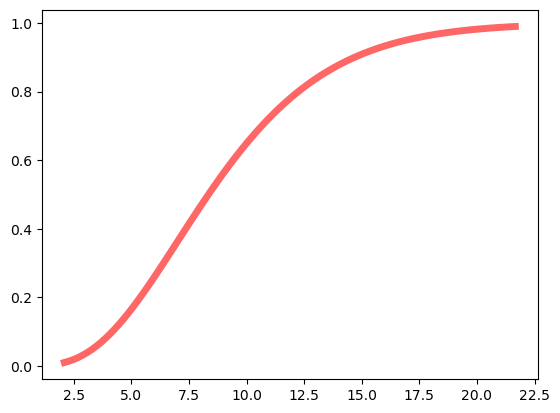

In [40]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

df = 9

x = np.linspace(chi2.ppf(0.01, df),

                chi2.ppf(0.99, df), 100)

ax.plot(x, chi2.cdf(x, df),

       'r-', lw=5, alpha=0.6, label='t pdf')

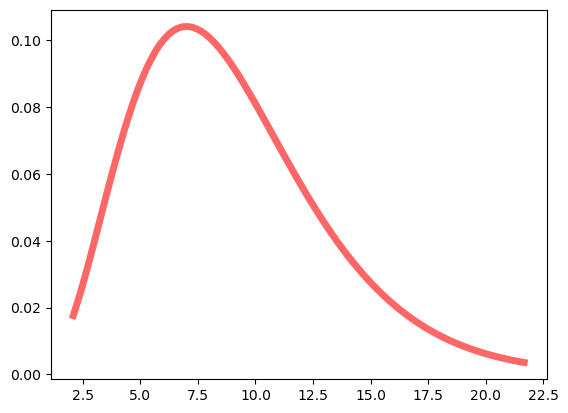

In [41]:
# Chi square dist has the average equal to df
# but not the max point of pdf is df, since it is not symetric
# the mean point is on the right side of the max point

fig, ax = plt.subplots(1, 1)

df = 9

x = np.linspace(chi2.ppf(0.01, df),

                chi2.ppf(0.99, df), 100)

ax.plot(x, chi2.pdf(x, df),

       'r-', lw=5, alpha=0.6, label='t pdf')